# Customer Segmentation

In [1]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np #linear algebra
import pandas as pd # data processing, CSV file
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # for plotting
import lifetimes
import squarify
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

In [2]:
order_prod_prior = pd.read_csv('./archive (1)/order_products__prior.csv')
orders = pd.read_csv('./archive (1)/orders.csv')

In [3]:
df = pd.merge(orders,order_prod_prior,on =['order_id','order_id'])

In [5]:
df_order = df.groupby('order_id').count()[['product_id']]
df_order.rename(columns = {'product_id':'Total_products'},inplace = True)

In [6]:
usr_data = orders.join(df_order,how='inner',on='order_id')
usr_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Total_products
0,2539329,1,prior,1,2,8,NaN,5
1,2398795,1,prior,2,3,7,15.0,6
2,473747,1,prior,3,3,12,21.0,5
3,2254736,1,prior,4,4,7,29.0,5
4,431534,1,prior,5,4,15,28.0,8


In [9]:
freq = usr_data.groupby('user_id')['order_number'].max()
recency = round(usr_data.groupby('user_id')['days_since_prior_order'].mean(),0)
monetary_value=usr_data.groupby('user_id')['Total_products'].sum()
T = usr_data.groupby('user_id')['days_since_prior_order'].sum()

In [10]:
rfm = pd.concat([freq,recency,monetary_value,T],axis =1)
rfm.columns = ['frequency','recency','monetary_value','T']
rfm.head()

,frequency,recency,monetary_value,T
user_id,,,,
1,10,20.0,59,176.0
2,14,15.0,195,198.0
3,12,12.0,88,133.0
4,5,14.0,18,55.0
5,4,13.0,37,40.0


In [11]:
rfm.isna().sum()

frequency         0
recency           0
monetary_value    0
T                 0
dtype: int64

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'],rfm['recency'],rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 206209 subjects, a: 32.06, alpha: 0.32, b: 492.80, r: 0.62>

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

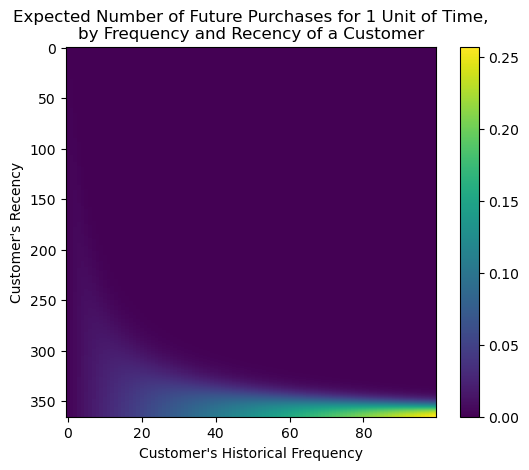

In [15]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

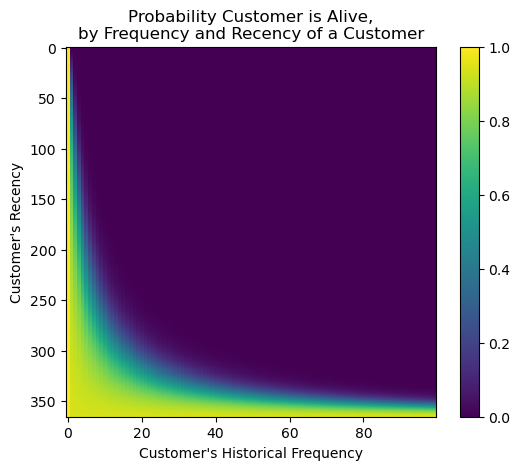

In [17]:
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

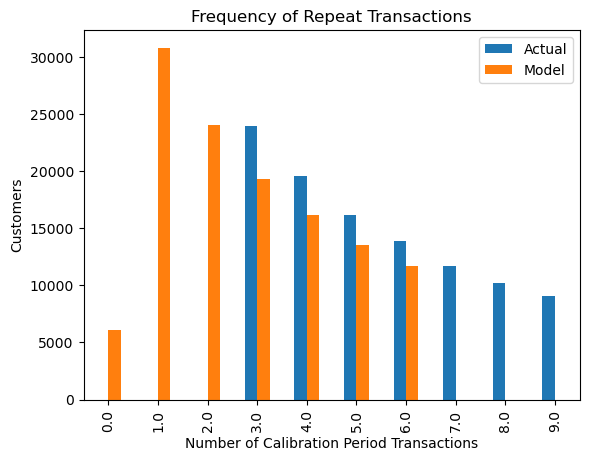

In [19]:
plot_period_transactions(bgf)

In [20]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm['frequency'],
        rfm['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 206209 subjects, p: 0.31, q: 1.97, v: 639.22>

In [21]:
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm['clv'] = clv

#Print the top 10 most valued customers
rfm.sort_values('clv', ascending=False).head(10)

,frequency,recency,monetary_value,T,clv
user_id,,,,,
9515,3,0.0,39,0.0,1944.286761
115420,3,0.0,39,0.0,1944.286761
58934,3,0.0,25,0.0,1836.302573
121915,3,0.0,24,0.0,1828.589416
179078,3,0.0,24,0.0,1828.589416
133075,3,0.0,21,0.0,1805.449948
125717,3,0.0,15,0.0,1759.171010
131603,3,0.0,14,0.0,1751.457853
137150,3,0.0,12,0.0,1736.031541


In [22]:
rfm_df = rfm.drop(['T','clv'], axis=1)
rfm_df.columns = ['Frequency', 'Recency', 'Monetary']

In [23]:
rfm_df.head()

,Frequency,Recency,Monetary
user_id,,,
1,10,20.0,59
2,14,15.0,195
3,12,12.0,88
4,5,14.0,18
5,4,13.0,37


In [24]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Frequency,Recency,Monetary
0.25,5.0,9.0,39.0
0.50,9.0,14.0,83.0
0.75,19.0,20.0,188.0


In [25]:
quantiles.to_dict()

{'Frequency': {0.25: 5.0, 0.5: 9.0, 0.75: 19.0},
 'Recency': {0.25: 9.0, 0.5: 14.0, 0.75: 20.0},
 'Monetary': {0.25: 39.0, 0.5: 83.0, 0.75: 188.0}}

In [26]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [27]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [28]:
rfm_segmentation.head()

,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile
user_id,,,,,,
1,10,20.0,59,2,3,2
2,14,15.0,195,2,3,4
3,12,12.0,88,3,3,3
4,5,14.0,18,3,1,1
5,4,13.0,37,3,1,1


In [30]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) + rfm_segmentation.F_Quartile.map(str) + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
user_id,,,,,,,
1,10,20.0,59,2,3,2,232
2,14,15.0,195,2,3,4,234
3,12,12.0,88,3,3,3,333
4,5,14.0,18,3,1,1,311
5,4,13.0,37,3,1,1,311
6,3,9.0,14,4,1,1,411
7,20,11.0,206,3,4,4,344
8,3,30.0,49,1,1,2,112
9,3,18.0,76,2,1,2,212


In [31]:
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',    # High frequency as well as monetary value with good recency
    'Potential Loyalists':'434', # High recency and monetary value, average frequency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'At Risk Customers':'244',   # Customer's shopping less often now who used to shop a lot
    'Can’t Lose Them':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [32]:
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))
rfm_segmentation['Segment'] = rfm_segmentation.RFMScore.map(lambda x: dict_segment.get(x))
rfm_segmentation['Segment']
rfm_segmentation.fillna('Others', inplace = True)
rfm_segmentation.reset_index()

,user_id,Frequency,Recency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
0,1,10,20.0,59,2,3,2,232,Others
1,2,14,15.0,195,2,3,4,234,Others
2,3,12,12.0,88,3,3,3,333,Others
3,4,5,14.0,18,3,1,1,311,Others
4,5,4,13.0,37,3,1,1,311,Others
...,...,...,...,...,...,...,...,...,...
206204,206205,3,20.0,32,2,1,1,211,Others
206205,206206,67,4.0,285,4,4,4,444,Best Customers
206206,206207,16,14.0,223,3,3,4,334,Big Spenders
206207,206208,49,7.0,677,4,4,4,444,Best Customers


In [33]:
rfm_segments = rfm_segmentation[rfm_segmentation.Segment!='Others'].reset_index().groupby('Segment')['user_id'].count().reset_index(name='counts')
rfm_segments

,Segment,counts
0,At Risk Customers,1532
1,Best Customers,24989
2,Big Spenders,3479
3,Lost Cheap Customers,6278
4,Loyal Customers,12509
5,Potential Loyalists,1775
6,Recent Customers,3945


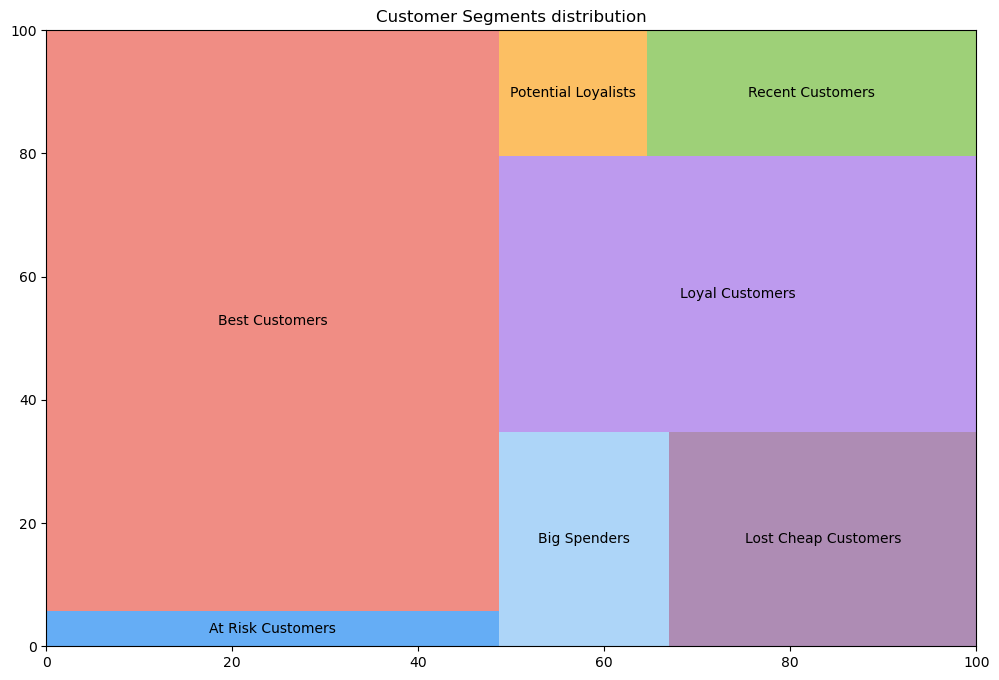

In [34]:
segment = list(rfm_segments.iloc[:8].Segment)
score = list(rfm_segments.iloc[:8].counts)
color_list = ["#248af1", "#eb5d50", "#8bc4f6", "#8c5c94", "#a170e8", "#fba521", "#75bc3f"]
plt.figure(figsize=(12,8))
plt.title('Customer Segments distribution')
squarify.plot(sizes=score, label=segment,color=color_list, alpha=0.7)

plt.show()

## Recommendations:

### Best Customers
We can give rewards and cashback offers to increase their purchases.

We can suggest them with premium memberships and offer special discounts.

Best to include free delivery options for Best Customers through premium memberships.

### Big Spenders

We can give discounts,free door delivery cashbacks based on a level of spending i.e shop above $30





### Lost Cheap Customers

Marketing Campigns like emails/sms with discount informations and moneyback can be sent to get back those customers

Also emails with valuable customer reviews might create an impact

### Loyal Customers

Same premium offer like best customers can be implemented with loyality benefits

### At Risk Customers

Emails, customised social media marketings might help to retain them